# Import thư viện

In [2]:
import numpy as np
from PIL import Image
import glob2
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import time

import logging
logging.getLogger("numba")
logging.disable(logging.WARNING)

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

## Import class SVM

In [4]:
from svm import *
from hog_class import *

# Hàm đọc dữ liệu

In [13]:
def read_data(link_cat, link_dog, n_samples, image_size = (400, 400), random_state = 42):
    list_cat = glob2.glob(link_cat)
    list_dog = glob2.glob(link_dog)
    cat_images = []
    cat_labels = []
    for i in range(int(n_samples/2)):
        if 'jpg' in list_cat[i]:
            img = Image.open(list_cat[i]).convert('RGB')
            img = img.resize(image_size, Image.LANCZOS)
            if len(np.array(img).shape) == 3:
                cat_images.append(np.array(img))
                cat_labels.append(1)
    dog_images = []
    dog_labels = []
    for i in range(int(n_samples/2)):
        if 'jpg' in list_dog[i]:
            img = Image.open(list_dog[i]).convert('RGB')
            img = img.resize(image_size, Image.LANCZOS)
            if len(np.array(img).shape) == 3:
                dog_images.append(np.array(img))
                dog_labels.append(-1)
    for index in range(len(cat_images)):
        if cat_images[index].shape[2] != 3:
            print(index, cat_images[index].shape[2])
    for index in range(len(dog_images)):
        if dog_images[index].shape[2] != 3:
            print(index, dog_images[index].shape[2])  
    cat_images = np.array(cat_images)
    cat_labels = np.array(cat_labels)
    dog_images = np.array(dog_images)
    dog_labels = np.array(dog_labels)
    
    x_cat_train, x_cat_test, y_cat_train, y_cat_test = train_test_split(cat_images, cat_labels, test_size=0.3, random_state = random_state)
    x_dog_train, x_dog_test, y_dog_train, y_dog_test = train_test_split(dog_images, dog_labels, test_size=0.3, random_state = random_state)
    X_train = np.concatenate((x_cat_train, x_dog_train), axis = 0)
    y_train = np.concatenate((y_cat_train, y_dog_train), axis = 0)
    X_test = np.concatenate((x_cat_test, x_dog_test), axis = 0)
    y_test = np.concatenate((y_cat_test, y_dog_test), axis = 0)

    s1 = np.arange(X_train.shape[0])
    random.Random(0).shuffle(s1)
    X_train = X_train.take(s1, axis = 0)
    y_train = y_train.take(s1, axis = 0)
    s2  = np.arange(X_test.shape[0])
    random.Random(5).shuffle(s2)
    X_test = X_test.take(s2, axis = 0)
    y_test = y_test.take(s2, axis = 0)
    
    return X_train, y_train, X_test, y_test

In [14]:
def big_fit(X_train, y_train, hog, svm):
    x_train = []
    t = 0
    for x in X_train:
        #print(t, end="  ")
        x_train.append(hog.compute_HOG(x))
        t+=1
    x_train = np.array(x_train)
    svm.fit(x_train, y_train)

def big_predict(X_test, hog, svm):
    x_test = []
    t = 0
    for x in X_test:
        #print(t, end = "  ")
        x_test.append(hog.compute_HOG(x))
        t+=1
    x_test = np.array(x_test)
    return svm.predict(x_test)

# So sánh

In [15]:
n_test = [100, 200, 300, 400, 500]
link_cat = r'C:\Users\dolek\Documents\GitHub\Applied-Parallel-Programming\Main\Data\Cat\**'
link_dog = r'C:\Users\dolek\Documents\GitHub\Applied-Parallel-Programming\Main\Data\Dog\**'

In [16]:
acc1 = []
acc2 = []
acc3 = []
acc4 = []
acc5 = []
time1 = []
time2 = []
time3 = []
time4 = []
time5 = []
blocksize = (2, 2)
cellsize = (8, 8)
nbin = 9
sbin = 40
threadperblock = (32, 32)
hog = HOG_CUDA_2(blocksize, cellsize, nbin, sbin, threadperblock)

In [17]:
for n in n_test:
    X_train, y_train, X_test, y_test = read_data(link_cat, link_dog, n, random_state = 0)
    
    x_train = np.array([x.flatten() for x in X_train])
    x_test = np.array([x.flatten() for x in X_test])
    
    y_train_sklearn = np.array([str(y) for y in y_train])
    y_test_sklearn = np.array([str(y) for y in y_test])
    
    
    start = time.time()
    svm = SVM_Old()
    big_fit(X_train, y_train, hog, svm)
    pred = big_predict(X_test, hog, svm)
    end = time.time()
    time1.append(end-start)
    acc1.append(accuracy_score(pred, y_test))
    
    start = time.time()
    svm = SVM_New(kernel = 'linear')
    big_fit(X_train, y_train, hog, svm)
    pred = big_predict(X_test, hog, svm)
    end = time.time()
    time2.append(end-start)
    acc2.append(accuracy_score(pred, y_test))
        
    start = time.time()
    svm = SVM_New(kernel = 'rbf')
    big_fit(X_train, y_train, hog, svm)
    pred = big_predict(X_test, hog, svm)
    end = time.time()
    time3.append(end-start)
    acc3.append(accuracy_score(pred, y_test))
    
    start = time.time()
    svm = SVC(kernel = 'linear', shrinking = False)
    big_fit(X_train, y_train_sklearn, hog, svm)
    pred = big_predict(X_test, hog, svm)
    end = time.time()
    time4.append(end-start)
    acc4.append(accuracy_score(pred, y_test_sklearn))
    
    start = time.time()
    svm = SVC(kernel = 'rbf', shrinking = False)
    big_fit(X_train, y_train_sklearn, hog, svm)
    pred = big_predict(X_test, hog, svm)
    end = time.time()
    time5.append(end-start)
    acc5.append(accuracy_score(pred, y_test_sklearn))

# Plot kết quả

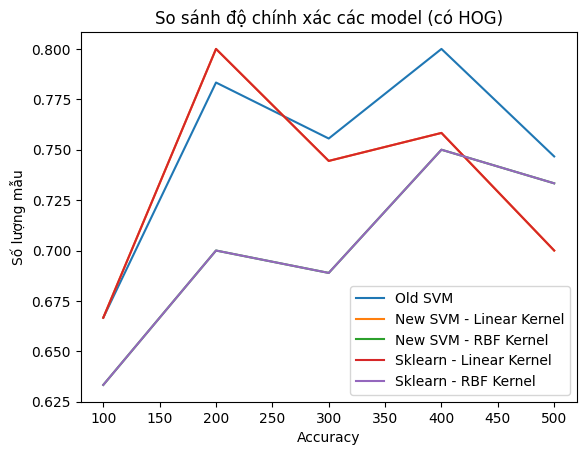

In [18]:
plt.plot(n_test, acc1, label = 'Old SVM')
plt.plot(n_test, acc2, label = 'New SVM - Linear Kernel')
plt.plot(n_test, acc3, label = 'New SVM - RBF Kernel')
plt.plot(n_test, acc4, label = 'Sklearn - Linear Kernel')
plt.plot(n_test, acc5, label = 'Sklearn - RBF Kernel')

plt.ylabel("Số lượng mẫu")
plt.xlabel("Accuracy")
plt.title("So sánh độ chính xác các model (có HOG)")
plt.legend()
plt.show()

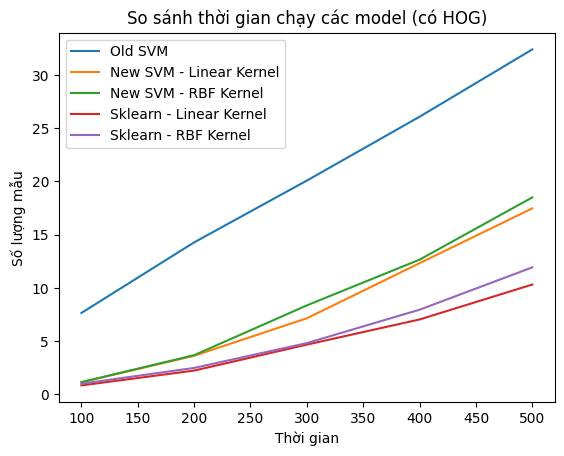

In [19]:
plt.plot(n_test, time1, label = 'Old SVM')
plt.plot(n_test, time2, label = 'New SVM - Linear Kernel')
plt.plot(n_test, time3, label = 'New SVM - RBF Kernel')
plt.plot(n_test, time4, label = 'Sklearn - Linear Kernel')
plt.plot(n_test, time5, label = 'Sklearn - RBF Kernel')

plt.ylabel("Số lượng mẫu")
plt.xlabel("Thời gian")
plt.title("So sánh thời gian chạy các model (có HOG)")
plt.legend()
plt.show()

## Kết quả của SVM mới

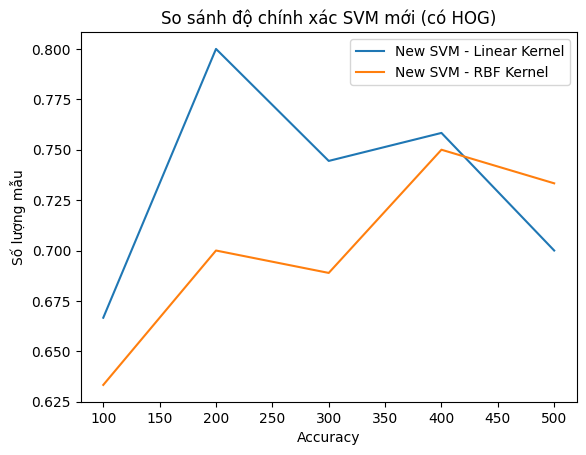

In [20]:
plt.plot(n_test, acc2, label = 'New SVM - Linear Kernel')
plt.plot(n_test, acc3, label = 'New SVM - RBF Kernel')

plt.ylabel("Số lượng mẫu")
plt.xlabel("Accuracy")
plt.title("So sánh độ chính xác SVM mới (có HOG)")
plt.legend()
plt.show()